## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [56]:
!pip install -q transformers datasets evaluate


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [57]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [58]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [59]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [60]:
from transformers import SegformerImageProcessor

root_dir = './ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

In [61]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [62]:
encoded_inputs = train_dataset[0]

In [63]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [64]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [65]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [66]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [67]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [68]:
batch = next(iter(train_dataloader))

In [69]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [70]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [71]:
mask = (batch["labels"] != 255)
mask

tensor([[[False, False, False,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]]])

In [72]:
batch["labels"][mask]

tensor([5, 5, 5,  ..., 3, 3, 3])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [73]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [74]:
import evaluate

metric = evaluate.load("mean_iou")

In [75]:
image_processor.do_reduce_labels

True

In [76]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# if torch.backends.mps.is_available():
#     device = torch.device("mps")

model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/thomasjones/.pyenv/versions/3.10.15/envs/segformer/lib/python3.10/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 4.986422538757324
Mean_iou: 0.0006154588385003447
Mean accuracy: 0.005553877252020122
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.989312171936035
Mean_iou: 0.0009436313651702819
Mean accuracy: 0.01459334552149378
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.7606329917907715
Mean_iou: 0.00628907201142598
Mean accuracy: 0.044623818325412776
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.645898342132568
Mean_iou: 0.011993334487142253
Mean accuracy: 0.1953517442154838
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.532933235168457
Mean_iou: 0.018687322567146197
Mean accuracy: 0.15149649130673168
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.275619029998779
Mean_iou: 0.04520486991528976
Mean accuracy: 0.25708039748284356
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.193750858306885
Mean_iou: 0.044269935405346975
Mean accuracy: 0.2507661569309868
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.100302696228027
Mean_iou: 0.07517942402473142
Mean accuracy: 0.31135612388016487
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.928896427154541
Mean_iou: 0.08390247032238216
Mean accuracy: 0.1920092022782821
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.6860196590423584
Mean_iou: 0.07364017539770121
Mean accuracy: 0.21051148944818432
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.697476387023926
Mean_iou: 0.10047025262605246
Mean accuracy: 0.25350762430324303
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.4814345836639404
Mean_iou: 0.05996628520196675
Mean accuracy: 0.15371688646804674
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.4033687114715576
Mean_iou: 0.18039886131532964
Mean accuracy: 0.5322394736900973
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.7141964435577393
Mean_iou: 0.11380976790121385
Mean accuracy: 0.37964299964378345
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.4276859760284424
Mean_iou: 0.20728479428146235
Mean accuracy: 0.6071804147300787
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.338728904724121
Mean_iou: 0.18987123847651882
Mean accuracy: 0.29748440277868576
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.764547824859619
Mean_iou: 0.08487073554110776
Mean accuracy: 0.15850188315629032
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.2863752841949463
Mean_iou: 0.12450882136364355
Mean accuracy: 0.3744340517487019
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7433116436004639
Mean_iou: 0.3871356095153558
Mean accuracy: 0.60234374248995
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.938033103942871
Mean_iou: 0.2254536574749401
Mean accuracy: 0.39498188600168066
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.1533827781677246
Mean_iou: 0.16418322533282
Mean accuracy: 0.4298722421291581
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6297173500061035
Mean_iou: 0.39081383905608374
Mean accuracy: 0.4790404410804606
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.675093650817871
Mean_iou: 0.23854352822948274
Mean accuracy: 0.3764581521129575
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9416570663452148
Mean_iou: 0.3455401189923959
Mean accuracy: 0.5581713592339214
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5677835941314697
Mean_iou: 0.2286383182575986
Mean accuracy: 0.3067985190344066
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.606506109237671
Mean_iou: 0.08637536406255587
Mean accuracy: 0.13380778827351525
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.551409959793091
Mean_iou: 0.17227799740174313
Mean accuracy: 0.2961207301627779
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6670305728912354
Mean_iou: 0.29551476108515545
Mean accuracy: 0.47922647706393245
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1881940364837646
Mean_iou: 0.17363906796391648
Mean accuracy: 0.25982321686909715
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6377665996551514
Mean_iou: 0.1618825270151943
Mean accuracy: 0.3076973992564813
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.176560401916504
Mean_iou: 0.42600833129111154
Mean accuracy: 0.5729643606470376
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0501739978790283
Mean_iou: 0.18455727264052277
Mean accuracy: 0.2725571749974088
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9728987812995911
Mean_iou: 0.4256061660312009
Mean accuracy: 0.6063270985226888
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.076967477798462
Mean_iou: 0.11160910546524487
Mean accuracy: 0.16644455163240002
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5411803722381592
Mean_iou: 0.31497176657137954
Mean accuracy: 0.46800573022214886
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8878041505813599
Mean_iou: 0.21018242835588483
Mean accuracy: 0.3148461132219473
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3723602294921875
Mean_iou: 0.2208916613837808
Mean accuracy: 0.44371722497822225
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.002768039703369
Mean_iou: 0.3592030873361702
Mean accuracy: 0.44144178295070124
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5537641048431396
Mean_iou: 0.35938147872322507
Mean accuracy: 0.5464700978519074
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.971143126487732
Mean_iou: 0.31107552611931355
Mean accuracy: 0.5052568184826078
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8714909553527832
Mean_iou: 0.23576809825124456
Mean accuracy: 0.3089080326582544
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8241275548934937
Mean_iou: 0.13204423584691047
Mean accuracy: 0.20116692135153535
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5092217922210693
Mean_iou: 0.31294782047060554
Mean accuracy: 0.5479053531731558
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.941880226135254
Mean_iou: 0.47311927161966005
Mean accuracy: 0.5720545397366743
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.189656376838684
Mean_iou: 0.40549056291560603
Mean accuracy: 0.518349675602116
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6377766132354736
Mean_iou: 0.5402612695419899
Mean accuracy: 0.7117462188887184
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2274000644683838
Mean_iou: 0.3253700333411181
Mean accuracy: 0.4846576228739208
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9092270135879517
Mean_iou: 0.1308006920927385
Mean accuracy: 0.19278701778853957
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4349079132080078
Mean_iou: 0.23061481234597325
Mean accuracy: 0.3205970905802512
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7632808685302734
Mean_iou: 0.12049231318852682
Mean accuracy: 0.1959617409806384
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5149834156036377
Mean_iou: 0.3596812257302109
Mean accuracy: 0.4828137697154181
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2393105030059814
Mean_iou: 0.3765317746343169
Mean accuracy: 0.5227095697629952
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0812108516693115
Mean_iou: 0.34598189118486145
Mean accuracy: 0.5406971123265777
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3054406642913818
Mean_iou: 0.10360814138044493
Mean accuracy: 0.1675329400945807
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5459280014038086
Mean_iou: 0.21135297756569407
Mean accuracy: 0.26786933506668714
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6855881214141846
Mean_iou: 0.2918873169401299
Mean accuracy: 0.3712033118949378
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4584856033325195
Mean_iou: 0.1455163098699421
Mean accuracy: 0.21045007358173107
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0724834203720093
Mean_iou: 0.49643119316976897
Mean accuracy: 0.7125156439851595
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3471684455871582
Mean_iou: 0.33810632661645007
Mean accuracy: 0.4871883680451078
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9635338187217712
Mean_iou: 0.6201526469926387
Mean accuracy: 0.7300826166675429
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9197072982788086
Mean_iou: 0.6230948143646685
Mean accuracy: 0.7284969322556116
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8090739250183105
Mean_iou: 0.21087481969130897
Mean accuracy: 0.29870271111960983
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4795703887939453
Mean_iou: 0.25824316140896597
Mean accuracy: 0.32486646860128987
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5688350200653076
Mean_iou: 0.8107313323079111
Mean accuracy: 0.853073589192795
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4532603025436401
Mean_iou: 0.364898436126036
Mean accuracy: 0.5456822840900947
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.325555443763733
Mean_iou: 0.29406511829492854
Mean accuracy: 0.40676237754885153
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9368922710418701
Mean_iou: 0.21599475841266955
Mean accuracy: 0.304538755450118
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8901931643486023
Mean_iou: 0.2213948162182192
Mean accuracy: 0.30884026448595064
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5385892391204834
Mean_iou: 0.2334473728804847
Mean accuracy: 0.35120486606507023
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.509577989578247
Mean_iou: 0.12756511962550465
Mean accuracy: 0.20451494460997152
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3002463579177856
Mean_iou: 0.4677412877209874
Mean accuracy: 0.5800879372260048
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1789813041687012
Mean_iou: 0.48827720546554126
Mean accuracy: 0.6032334813727801
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1646968126296997
Mean_iou: 0.2148969490068615
Mean accuracy: 0.3283363477826894
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2019277811050415
Mean_iou: 0.2631100365055681
Mean accuracy: 0.34731679410929234
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8319933414459229
Mean_iou: 0.3362424053270465
Mean accuracy: 0.6078132013626663
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0570766925811768
Mean_iou: 0.19865957331283363
Mean accuracy: 0.33664046461865454
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9780277013778687
Mean_iou: 0.4891440466808467
Mean accuracy: 0.7358011423862172
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9026845097541809
Mean_iou: 0.15296961779401838
Mean accuracy: 0.2194905765467891
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39774465560913086
Mean_iou: 0.7314002163886196
Mean accuracy: 0.8467343925847834
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0196810960769653
Mean_iou: 0.5689412677642605
Mean accuracy: 0.6639784888409493
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8294314742088318
Mean_iou: 0.7306833648005682
Mean accuracy: 0.7939667531873521
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8574900031089783
Mean_iou: 0.25762187856194396
Mean accuracy: 0.32605990558197223
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.31168967485427856
Mean_iou: 0.3998709193283281
Mean accuracy: 0.6182974953245245
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8329645395278931
Mean_iou: 0.5419727456329395
Mean accuracy: 0.6566113056799436
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1459068059921265
Mean_iou: 0.37154598344059614
Mean accuracy: 0.5810109710051065
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47278276085853577
Mean_iou: 0.39445752660163313
Mean accuracy: 0.5517974084242853
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8510999083518982
Mean_iou: 0.28842466463472405
Mean accuracy: 0.36143124436235424
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7160764932632446
Mean_iou: 0.7409549826213255
Mean accuracy: 0.797009561046941
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7164088487625122
Mean_iou: 0.2757325667531849
Mean accuracy: 0.45995449249895454
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4399626851081848
Mean_iou: 0.606671426223937
Mean accuracy: 0.7767185235095269
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26148125529289246
Mean_iou: 0.3745076596810594
Mean accuracy: 0.6278199496979279
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0425958633422852
Mean_iou: 0.2906498938533035
Mean accuracy: 0.3599859091456099
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6961438059806824
Mean_iou: 0.2582084409056968
Mean accuracy: 0.3446085862068447
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5122824907302856
Mean_iou: 0.31725645864146
Mean accuracy: 0.6011212544787012
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8741794228553772
Mean_iou: 0.25873098647972803
Mean accuracy: 0.37481658445525384
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4596319794654846
Mean_iou: 0.5632339424644076
Mean accuracy: 0.800931365888471
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0547137260437012
Mean_iou: 0.47796727018739055
Mean accuracy: 0.5560684792364368
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.212858185172081
Mean_iou: 0.4110017820699369
Mean accuracy: 0.6814798732686645
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9685988426208496
Mean_iou: 0.3408508719036544
Mean accuracy: 0.4806874577421613
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2843421697616577
Mean_iou: 0.8182736889289919
Mean accuracy: 0.8460356476821745
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9348592758178711
Mean_iou: 0.29604905163879003
Mean accuracy: 0.3789531403674713
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28878679871559143
Mean_iou: 0.6625727769474826
Mean accuracy: 0.8430225449118662
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.562121570110321
Mean_iou: 0.38644445731522153
Mean accuracy: 0.5063319523585939
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35286739468574524
Mean_iou: 0.48025630816412895
Mean accuracy: 0.5972685679688294
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.710269570350647
Mean_iou: 0.3074561024722567
Mean accuracy: 0.3823049478416378
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4820912480354309
Mean_iou: 0.45562551866483203
Mean accuracy: 0.7092870379650856
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8223546147346497
Mean_iou: 0.5580748913760293
Mean accuracy: 0.626669975575875
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6363614797592163
Mean_iou: 0.514358703185036
Mean accuracy: 0.5950598231849571
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5176354050636292
Mean_iou: 0.43819470381490955
Mean accuracy: 0.5632738075835706
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7047008872032166
Mean_iou: 0.17559986694776275
Mean accuracy: 0.28665752250922993
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7530176639556885
Mean_iou: 0.48433655161141387
Mean accuracy: 0.5665464349712526
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6308121085166931
Mean_iou: 0.594460115144747
Mean accuracy: 0.6815425732977959
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24041689932346344
Mean_iou: 0.8083407845781844
Mean accuracy: 0.8320088186890491
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6762846112251282
Mean_iou: 0.299911364339562
Mean accuracy: 0.3884249429002841
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7402513027191162
Mean_iou: 0.24908652696588537
Mean accuracy: 0.3141635499255745
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4787467122077942
Mean_iou: 0.561596397061012
Mean accuracy: 0.7286942150475165
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7604120373725891
Mean_iou: 0.30526029729343557
Mean accuracy: 0.36490321936852216
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5359856486320496
Mean_iou: 0.30564062494826977
Mean accuracy: 0.5063123152328685
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2946995496749878
Mean_iou: 0.803179109063238
Mean accuracy: 0.822081617408267
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.30648699402809143
Mean_iou: 0.5294644961372525
Mean accuracy: 0.6186546795551968
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6556949615478516
Mean_iou: 0.6013073112189126
Mean accuracy: 0.675217206743331
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6233648657798767
Mean_iou: 0.5850503287039857
Mean accuracy: 0.6720735971622932
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.703076958656311
Mean_iou: 0.5011408061595418
Mean accuracy: 0.5635773150024134
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5861220359802246
Mean_iou: 0.3198931776258007
Mean accuracy: 0.36039966828838793
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5077753067016602
Mean_iou: 0.6043358138683625
Mean accuracy: 0.678546916310986
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7067871689796448
Mean_iou: 0.3492173646580681
Mean accuracy: 0.39200390904571425
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2253475934267044
Mean_iou: 0.8307380183444307
Mean accuracy: 0.8462843873744337
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5278399586677551
Mean_iou: 0.6606034013111776
Mean accuracy: 0.6864378774313781
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5195082426071167
Mean_iou: 0.6081399634448528
Mean accuracy: 0.6787114137387528
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5985289216041565
Mean_iou: 0.4627096423066714
Mean accuracy: 0.5395543225564312
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5335416197776794
Mean_iou: 0.46208399596296895
Mean accuracy: 0.5086850686360174
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.667026162147522
Mean_iou: 0.3617562112865067
Mean accuracy: 0.4449263784037354
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6736843585968018
Mean_iou: 0.3924450989027757
Mean accuracy: 0.521015996238156
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6280053853988647
Mean_iou: 0.42351650190704904
Mean accuracy: 0.5293510759024805
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3462495505809784
Mean_iou: 0.5899861149314888
Mean accuracy: 0.6655964261962293
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3787964880466461
Mean_iou: 0.811656537651221
Mean accuracy: 0.8519227429213833
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49354642629623413
Mean_iou: 0.7050889334258987
Mean accuracy: 0.7472689928811419
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2305702120065689
Mean_iou: 0.8371763430032408
Mean accuracy: 0.8727026357494019
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6451947093009949
Mean_iou: 0.5514391463471986
Mean accuracy: 0.6418137582907594
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4306212067604065
Mean_iou: 0.6631452630405792
Mean accuracy: 0.6901601970704506
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4838041067123413
Mean_iou: 0.6169690512207953
Mean accuracy: 0.6891951803894811
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49980130791664124
Mean_iou: 0.3307084119181174
Mean accuracy: 0.49039727315644904
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49986347556114197
Mean_iou: 0.31134730043781583
Mean accuracy: 0.3705311246039045
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35352852940559387
Mean_iou: 0.8220770106305954
Mean accuracy: 0.8591316239527056
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6155126094818115
Mean_iou: 0.3734794237804026
Mean accuracy: 0.4170218580358611
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5315685868263245
Mean_iou: 0.5600491318907485
Mean accuracy: 0.6200547862159281
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18736426532268524
Mean_iou: 0.9197214765339122
Mean accuracy: 0.9465405468391668
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.493595153093338
Mean_iou: 0.5369000676508147
Mean accuracy: 0.5788073471305346
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3870455324649811
Mean_iou: 0.3374227354630413
Mean accuracy: 0.5250527421534588
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39755693078041077
Mean_iou: 0.657884699091326
Mean accuracy: 0.6883495282372754
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47068294882774353
Mean_iou: 0.5409750168558999
Mean accuracy: 0.5797129731194256
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29094836115837097
Mean_iou: 0.5087156029249598
Mean accuracy: 0.6029607328719913
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13127993047237396
Mean_iou: 0.4783320924446295
Mean accuracy: 0.7281263554424958
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6014978885650635
Mean_iou: 0.44271101260606477
Mean accuracy: 0.4850934203397917
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44901710748672485
Mean_iou: 0.5022517992354418
Mean accuracy: 0.5402550425293623
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2641370892524719
Mean_iou: 0.6290154829574266
Mean accuracy: 0.7012971999448139
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10808555036783218
Mean_iou: 0.47617411858989017
Mean accuracy: 0.7240933853443435
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4658791720867157
Mean_iou: 0.47311849860785726
Mean accuracy: 0.5593673876486919
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41526922583580017
Mean_iou: 0.5683439000671805
Mean accuracy: 0.6229737761489009
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26869046688079834
Mean_iou: 0.6697254001351073
Mean accuracy: 0.700488818040571
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5821043252944946
Mean_iou: 0.6322485150494319
Mean accuracy: 0.7752756863869653
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32783305644989014
Mean_iou: 0.9076816244344508
Mean accuracy: 0.9353336689146852
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34938937425613403
Mean_iou: 0.49981448344851626
Mean accuracy: 0.7730221916702549
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19374528527259827
Mean_iou: 0.3995735263773907
Mean accuracy: 0.716001032319328
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.417817622423172
Mean_iou: 0.4806696753362722
Mean accuracy: 0.5184111255740411
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4313158392906189
Mean_iou: 0.7228093765327347
Mean accuracy: 0.7510309239343635
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28601571917533875
Mean_iou: 0.44751992601152196
Mean accuracy: 0.6122319577063183
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44657063484191895
Mean_iou: 0.3715939868367842
Mean accuracy: 0.4215648122440693
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5667652487754822
Mean_iou: 0.3678654775120907
Mean accuracy: 0.40145480504896003
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5104544758796692
Mean_iou: 0.5412802941596575
Mean accuracy: 0.5882022477052441
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5155802965164185
Mean_iou: 0.40347070632631554
Mean accuracy: 0.44505574324369707
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3607766628265381
Mean_iou: 0.5615241330683911
Mean accuracy: 0.60253429780896
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13324546813964844
Mean_iou: 0.9494043048143045
Mean accuracy: 0.9673809759564875
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.418792188167572
Mean_iou: 0.4747514272873738
Mean accuracy: 0.5128950853914412
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18853668868541718
Mean_iou: 0.4219141262001036
Mean accuracy: 0.7146261992311809
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.295522004365921
Mean_iou: 0.9146949928938781
Mean accuracy: 0.9417351147873408
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15456445515155792
Mean_iou: 0.8426660614262355
Mean accuracy: 0.8576675867931759
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4465828835964203
Mean_iou: 0.47540546026891856
Mean accuracy: 0.548118834114512
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3108462989330292
Mean_iou: 0.6910350728293795
Mean accuracy: 0.7254640026739284
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1914139986038208
Mean_iou: 0.5795829866214773
Mean accuracy: 0.7778877506040469
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41891559958457947
Mean_iou: 0.597348516747292
Mean accuracy: 0.6693461639241766
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1357792317867279
Mean_iou: 0.8530478341557101
Mean accuracy: 0.8702404033070531
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21078276634216309
Mean_iou: 0.5664348672408314
Mean accuracy: 0.6273098724394421
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4659788906574249
Mean_iou: 0.4170845236633792
Mean accuracy: 0.45612851145610617
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11456213891506195
Mean_iou: 0.9624656934932431
Mean accuracy: 0.9768886298703443
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4574364125728607
Mean_iou: 0.44454535844731413
Mean accuracy: 0.6210479059196649
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4244341552257538
Mean_iou: 0.5750769496178327
Mean accuracy: 0.6823195242760317
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38525328040122986
Mean_iou: 0.36731630827595363
Mean accuracy: 0.438746488999142
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34242624044418335
Mean_iou: 0.5986009630904755
Mean accuracy: 0.6626737546549835
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21604302525520325
Mean_iou: 0.41759480319961007
Mean accuracy: 0.7033636101258763
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14422951638698578
Mean_iou: 0.8349185924194542
Mean accuracy: 0.8519836770284478
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3693222105503082
Mean_iou: 0.527901045164395
Mean accuracy: 0.6125811197187231
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3837461471557617
Mean_iou: 0.5897938297610695
Mean accuracy: 0.6621562624674361
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.419193834066391
Mean_iou: 0.35746372221200584
Mean accuracy: 0.38247628858429933
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4121786057949066
Mean_iou: 0.6847915484076624
Mean accuracy: 0.7734307623422831
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3922312259674072
Mean_iou: 0.5797024334585058
Mean accuracy: 0.684637409766217
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2733916938304901
Mean_iou: 0.7012119998592066
Mean accuracy: 0.8146898206040933
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32666754722595215
Mean_iou: 0.23651673487323802
Mean accuracy: 0.3866437586122069
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33105629682540894
Mean_iou: 0.4233576755217296
Mean accuracy: 0.455192829597592
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32674333453178406
Mean_iou: 0.6107945970746922
Mean accuracy: 0.6522346451217287


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

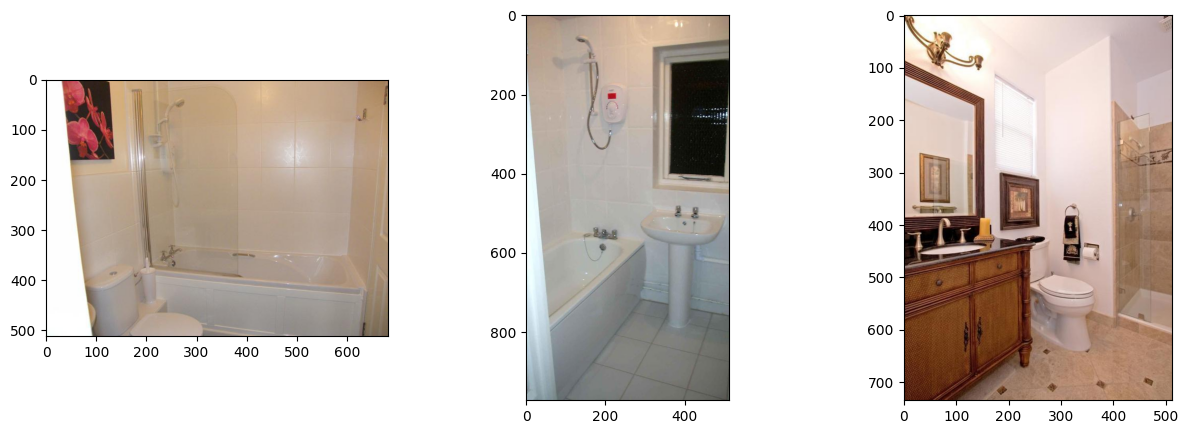

In [97]:
#pick 3 random images from the training set
import random

img1, img2, img3 = random.sample(range(1,len(train_dataset)+1), 3)

img1Str = str(img1).rjust(8, '0')
img2Str = str(img2).rjust(8, '0')
img3Str = str(img3).rjust(8, '0')

image1 = Image.open(f'./ADE20k_toy_dataset/images/training/ADE_train_{img1Str}.jpg')
image2 = Image.open(f'./ADE20k_toy_dataset/images/training/ADE_train_{img2Str}.jpg')
image3 = Image.open(f'./ADE20k_toy_dataset/images/training/ADE_train_{img3Str}.jpg')

#show the images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image1)
axs[1].imshow(image2)
axs[2].imshow(image3)

plt.show()


In [98]:
# prepare the image for the model
pixel_values1 = image_processor(image1, return_tensors="pt").pixel_values.to(device)
print(pixel_values1.shape)

pixel_values2 = image_processor(image2, return_tensors="pt").pixel_values.to(device)
print(pixel_values2.shape)

pixel_values3 = image_processor(image3, return_tensors="pt").pixel_values.to(device)
print(pixel_values3.shape)


torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


In [99]:
import torch

# forward pass
with torch.no_grad():
  outputs1 = model(pixel_values=pixel_values1)
  outputs2 = model(pixel_values=pixel_values2)
  outputs3 = model(pixel_values=pixel_values3)
  

In [100]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits1 = outputs1.logits.cpu()
print(logits1.shape)

logits2 = outputs2.logits.cpu()
print(logits2.shape)

logits3 = outputs3.logits.cpu()
print(logits3.shape)


torch.Size([1, 150, 128, 128])
torch.Size([1, 150, 128, 128])
torch.Size([1, 150, 128, 128])


In [101]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [102]:
predicted_segmentation_map1 = image_processor.post_process_semantic_segmentation(outputs1, target_sizes=[image1.size[::-1]])[0]
predicted_segmentation_map1 = predicted_segmentation_map1.cpu().numpy()
print(predicted_segmentation_map1)

predicted_segmentation_map2 = image_processor.post_process_semantic_segmentation(outputs2, target_sizes=[image2.size[::-1]])[0]
predicted_segmentation_map2 = predicted_segmentation_map2.cpu().numpy()
print(predicted_segmentation_map2)

predicted_segmentation_map3 = image_processor.post_process_semantic_segmentation(outputs3, target_sizes=[image3.size[::-1]])[0]
predicted_segmentation_map3 = predicted_segmentation_map3.cpu().numpy()
print(predicted_segmentation_map3)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [18 18 18 ...  3  3  3]
 [18 18 18 ...  3  3  3]
 [18 18 18 ...  3  3  3]]
[[ 5  5  5 ...  5  5  5]
 [ 5  5  5 ...  5  5  5]
 [ 5  5  5 ...  5  5  5]
 ...
 [10 10 10 ...  3  3  3]
 [10 10 10 ...  3  3  3]
 [10 10 10 ...  3  3  3]]


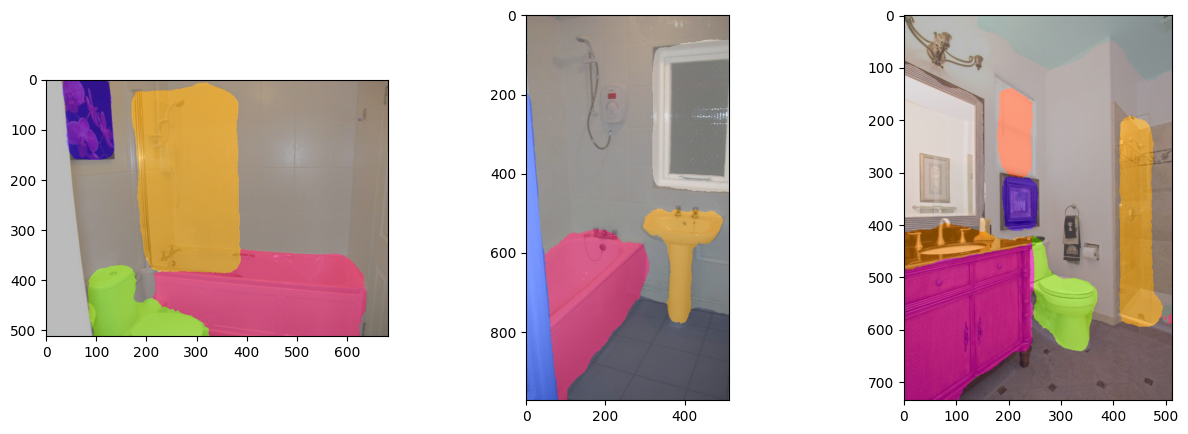

In [107]:
import matplotlib.pyplot as plt
import numpy as np

def show_segmentation_map(predicted_segmentation_map, image, ax):
    color_seg = np.zeros((predicted_segmentation_map.shape[0],
                        predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[predicted_segmentation_map == label, :] = color
    # Convert to BGR
    color_seg = color_seg[..., ::-1]

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    ax.imshow(img)
    # plt.show()

    return img

fig, axs = plt.subplots(1, 3, figsize=(15, 5))


img1 = show_segmentation_map(predicted_segmentation_map1, image1, axs[0])
img2 = show_segmentation_map(predicted_segmentation_map2, image2, axs[1])
img3 = show_segmentation_map(predicted_segmentation_map3, image3, axs[2])
plt.show()

Compare this to the ground truth segmentation map:

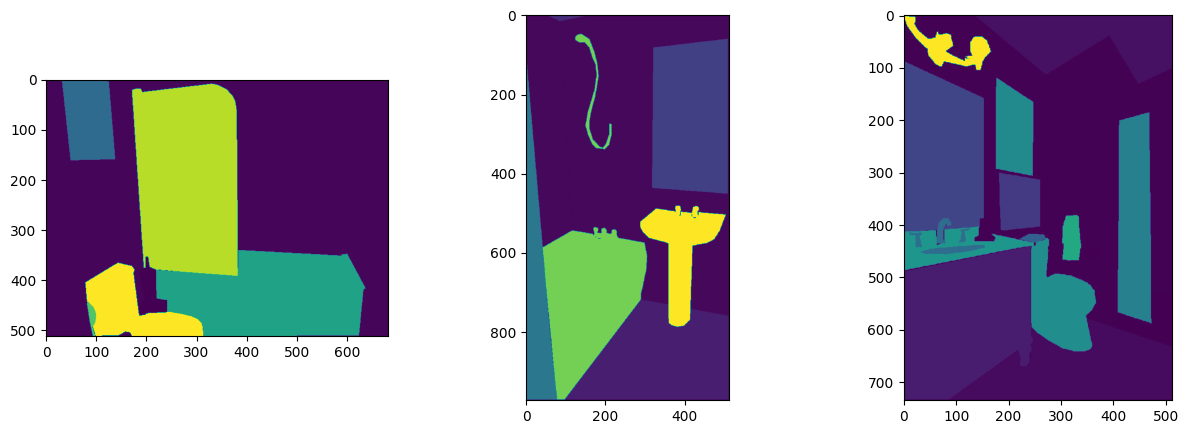

In [111]:
# map = Image.open('./ADE20k_toy_dataset/annotations/validation/ADE_val_00000004.png')
# map

map1 = Image.open(f'./ADE20k_toy_dataset/annotations/training/ADE_train_{img1Str}.png')
map2 = Image.open(f'./ADE20k_toy_dataset/annotations/training/ADE_train_{img2Str}.png')
map3 = Image.open(f'./ADE20k_toy_dataset/annotations/training/ADE_train_{img3Str}.png')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(map1)
axs[1].imshow(map2)
axs[2].imshow(map3)

plt.show()




Classes in this image: ['wall', 'painting', 'bathtub', 'sink', 'screen door', 'toilet', None]


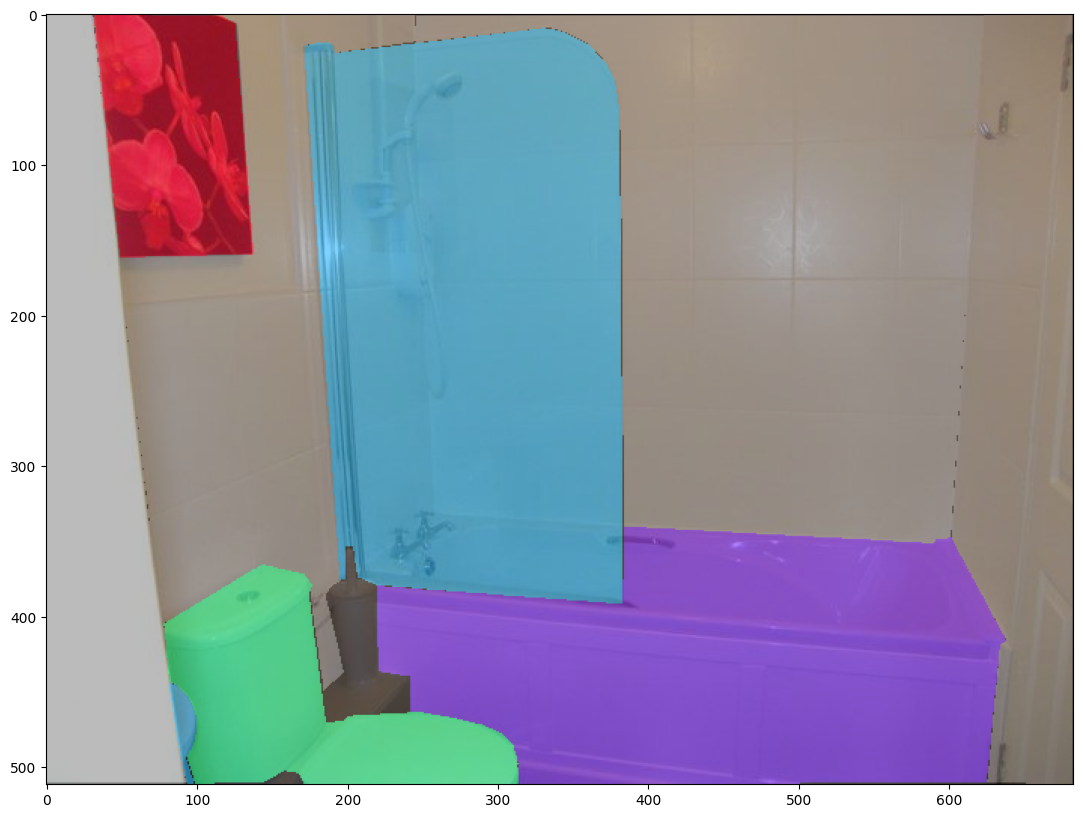

Classes in this image: ['wall', 'floor', 'ceiling', 'windowpane', 'curtain', 'bathtub', 'sink', None]


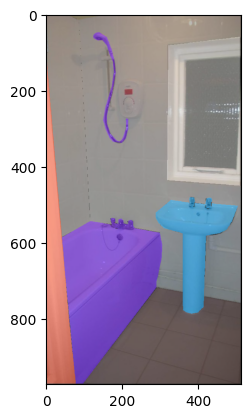

Classes in this image: ['wall', 'floor', 'ceiling', 'cabinet', 'painting', 'mirror', 'box', 'sink', 'screen door', 'blind', 'toilet', 'countertop', 'towel', 'sconce', None]


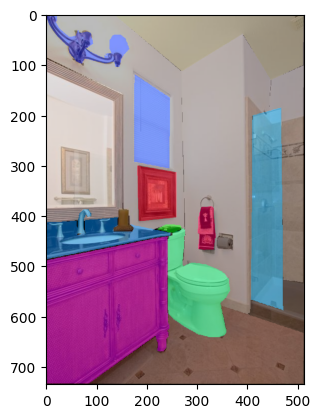

In [112]:
# convert map to NumPy array
import cv2

def show_mask_and_map(img, image, map):
    map = np.array(map)
    map[map == 0] = 255 # background class is replaced by ignore_index
    map = map - 1 # other classes are reduced by one
    map[map == 254] = 255

    classes_map = np.unique(map).tolist()
    unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
    print("Classes in this image:", unique_classes)

    # create coloured map
    color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[map == label, :] = color
    # Convert to BGR
    color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.imshow(img)
    plt.show()

    return map

plt.figure(figsize=(15, 10))

map1 = show_mask_and_map(img1, image1, map1)
map2 = show_mask_and_map(img2, image2, map2)
map3 = show_mask_and_map(img3, image3, map3)

Let's compute the metrics:

In [113]:
# metric expects a list of numpy arrays for both predictions and references
metrics1 = metric._compute(
                  predictions=[predicted_segmentation_map1],
                  references=[map1],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

metrics2 = metric._compute(
                  predictions=[predicted_segmentation_map2],
                  references=[map2],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

metrics3 = metric._compute(
                  predictions=[predicted_segmentation_map3],
                  references=[map3],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )



/Users/thomasjones/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/thomasjones/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [114]:
metrics1.keys()
metrics2.keys()
metrics3.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [115]:
import pandas as pd

def print_overall_metrics(metrics):
  # print overall metrics
  for key in list(metrics.keys())[:3]:
    print(key, metrics[key])

  # pretty-print per category metrics as Pandas DataFrame
  metric_table = dict()
  for id, label in id2label.items():
      metric_table[label] = [
                            metrics["per_category_iou"][id],
                            metrics["per_category_accuracy"][id]
      ]

  print("---------------------")
  print("per-category metrics:")
  pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])
  return metric_table

metric_table1 = print_overall_metrics(metrics1)
metric_table2 = print_overall_metrics(metrics2)
metric_table3 = print_overall_metrics(metrics3)

mean_iou 0.5305902842054846
mean_accuracy 0.8182955279132541
overall_accuracy 0.982802224125666
---------------------
per-category metrics:
mean_iou 0.8179979843388994
mean_accuracy 0.8402412977265518
overall_accuracy 0.9683384181121775
---------------------
per-category metrics:
mean_iou 0.5745240899594627
mean_accuracy 0.6565405571091382
overall_accuracy 0.9270174034368293
---------------------
per-category metrics:


In [116]:
print(metric_table1)
print(metric_table2)
print(metric_table3)
      

{'wall': [np.float64(0.9761351225683669), np.float64(0.9857981380873079)], 'building': [np.float64(nan), np.float64(nan)], 'sky': [np.float64(nan), np.float64(nan)], 'floor': [np.float64(0.0), np.float64(nan)], 'tree': [np.float64(nan), np.float64(nan)], 'ceiling': [np.float64(0.0), np.float64(nan)], 'road': [np.float64(nan), np.float64(nan)], 'bed ': [np.float64(nan), np.float64(nan)], 'windowpane': [np.float64(0.0), np.float64(nan)], 'grass': [np.float64(nan), np.float64(nan)], 'cabinet': [np.float64(nan), np.float64(nan)], 'sidewalk': [np.float64(nan), np.float64(nan)], 'person': [np.float64(nan), np.float64(nan)], 'earth': [np.float64(nan), np.float64(nan)], 'door': [np.float64(nan), np.float64(nan)], 'table': [np.float64(nan), np.float64(nan)], 'mountain': [np.float64(nan), np.float64(nan)], 'plant': [np.float64(nan), np.float64(nan)], 'curtain': [np.float64(nan), np.float64(nan)], 'chair': [np.float64(nan), np.float64(nan)], 'car': [np.float64(nan), np.float64(nan)], 'water': [np